In [186]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
import statsmodels as sm

### **Lettura dati**

In [187]:

def parser(s):
    return datetime.strptime(s, '%Y-%m')

In [ ]:
ice_cream_heater_df = pd.read_csv('ice_cream_vs_heater.csv', parse_dates=[0], index_col=0, date_parser=parser)

In [189]:
ice_cream_heater_df = ice_cream_heater_df.squeeze()

print(ice_cream_heater_df.head())

            heater  ice cream
Month                        
2004-01-01      27         13
2004-02-01      18         15
2004-03-01      14         16
2004-04-01      13         19
2004-05-01      13         21


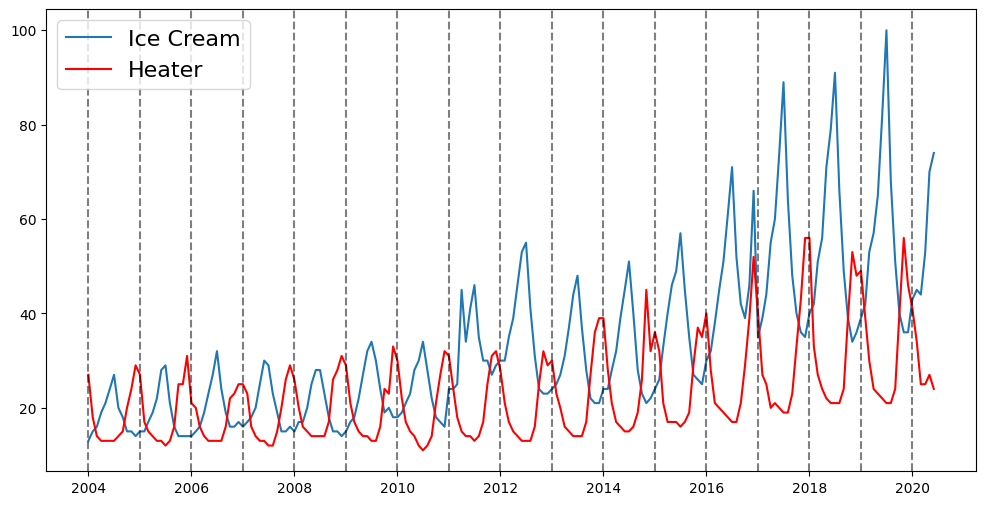

In [190]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

### **ADF**



In [191]:
result = adfuller(ice_cream_heater_df['ice cream'])

In [192]:
print('Statistiche ADF: %f' % result[0])
print('p-value: %f' % result[1])
print('Valori critici:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Statistiche ADF: -0.303933
p-value: 0.924945
Valori critici:
	1%: -3.466
	5%: -2.877
	10%: -2.575


In [193]:
result = adfuller(ice_cream_heater_df['heater'])

In [194]:
print('Statistiche ADF: %f' % result[0])
print('p-value: %f' % result[1])
print('Valori critici:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Statistiche ADF: 0.950111
p-value: 0.993711
Valori critici:
	1%: -3.466
	5%: -2.877
	10%: -2.575


### **Normalizzazione**

In [195]:
avgs = ice_cream_heater_df.mean()
devs = ice_cream_heater_df.std()

Standardizzo i valori della serie


In [196]:
for col in ice_cream_heater_df.columns:
    ice_cream_heater_df[col] = (ice_cream_heater_df[col] - avgs.loc[col]) / devs.loc[col]

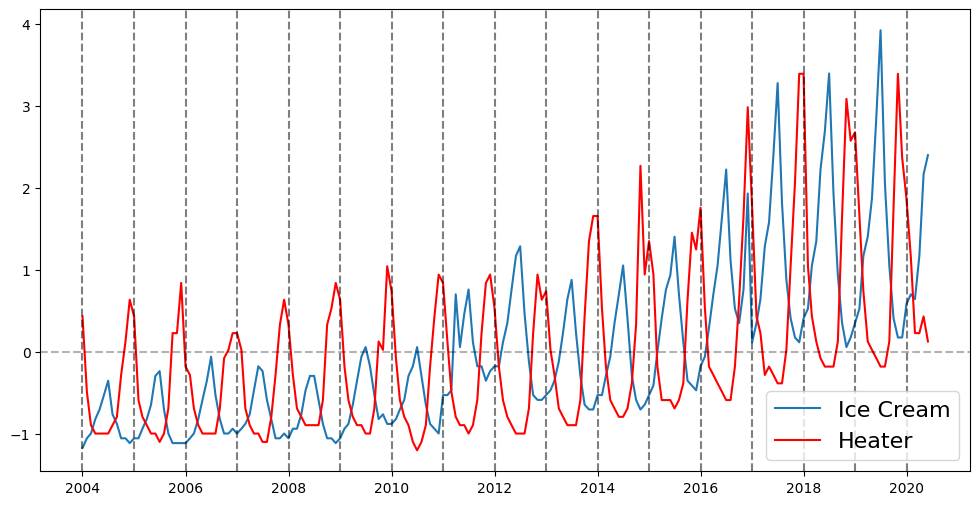

In [197]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

### **Differenziazione per rimuore il trend**

In [198]:
ice_cream_heater_df = ice_cream_heater_df.diff().dropna()

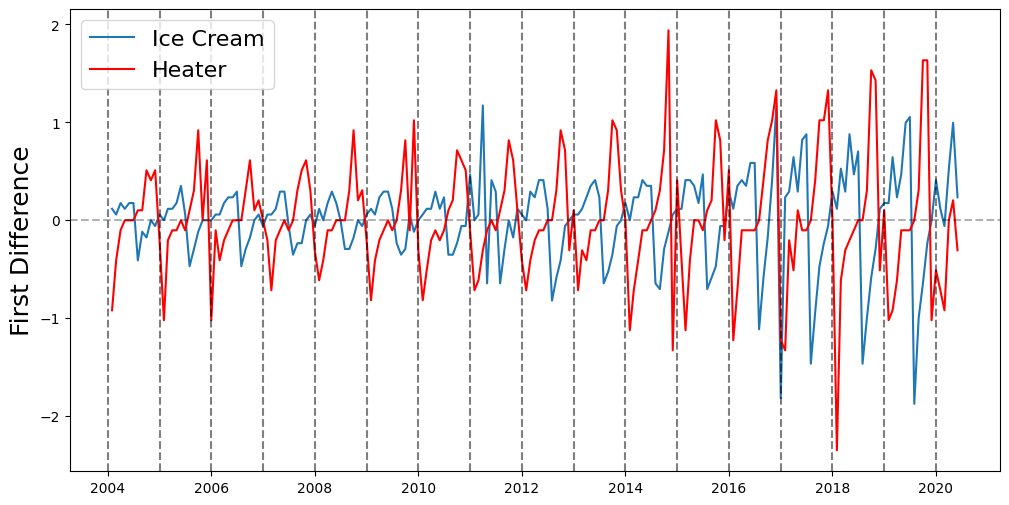

In [199]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

### **Rimuovo volatità**

Calcolo la deviazione standard annua

In [200]:
annual_volatility = ice_cream_heater_df.groupby(ice_cream_heater_df.index.year).std()

In [201]:
annual_volatility

,heater,ice cream
Month,,
2004,0.415481,0.184201
2005,0.474527,0.214837
2006,0.400148,0.227698
2007,0.359839,0.198947
2008,0.396182,0.183239
2009,0.499810,0.221038
2010,0.459566,0.211668
2011,0.443924,0.501018
2012,0.471104,0.389711


In [202]:
ice_cream_heater_df['ice_cream_annual_vol'] = ice_cream_heater_df.index.map(lambda d: annual_volatility.loc[d.year, 'ice cream'])
ice_cream_heater_df['heater_annual_vol'] = ice_cream_heater_df.index.map(lambda d: annual_volatility.loc[d.year, 'heater'])

In [203]:

ice_cream_heater_df

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol
Month,,,,
2004-02-01,-0.918789,0.117140,0.184201,0.415481
2004-03-01,-0.408351,0.058570,0.184201,0.415481
2004-04-01,-0.102088,0.175710,0.184201,0.415481
2004-05-01,0.000000,0.117140,0.184201,0.415481
2004-06-01,0.000000,0.175710,0.184201,0.415481
...,...,...,...,...
2020-02-01,-0.714614,0.117140,0.369810,0.426657
2020-03-01,-0.918789,-0.058570,0.369810,0.426657
2020-04-01,0.000000,0.527129,0.369810,0.426657


In [204]:
ice_cream_heater_df['ice cream'] = ice_cream_heater_df['ice cream'] / ice_cream_heater_df['ice_cream_annual_vol']
ice_cream_heater_df['heater'] = ice_cream_heater_df['heater'] / ice_cream_heater_df['heater_annual_vol']

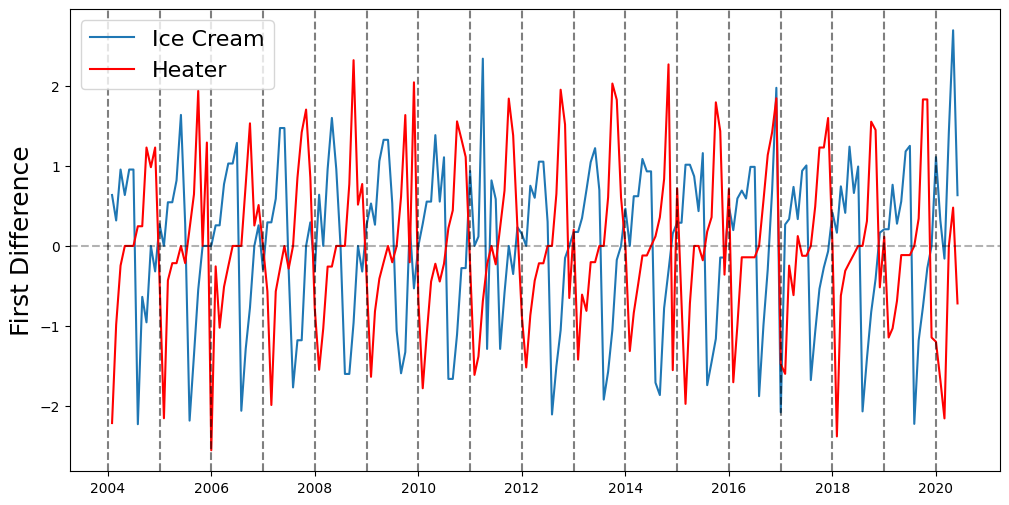

In [205]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

### **Rimuovo stagionalità**

In [206]:
month_avgs = ice_cream_heater_df.groupby(ice_cream_heater_df.index.month).mean()

In [207]:
print(month_avgs)


         heater  ice cream  ice_cream_annual_vol  heater_annual_vol
Month                                                              
1     -0.428360   0.130345              0.415976           0.580717
2     -1.483129   0.250194              0.402342           0.570997
3     -1.063595   0.433016              0.402342           0.570997
4     -0.442926   0.838085              0.402342           0.570997
5     -0.121663   0.967273              0.402342           0.570997
6     -0.128425   0.987311              0.402342           0.570997
7     -0.107093   0.735052              0.404376           0.580018
8      0.075720  -1.821285              0.404376           0.580018
9      0.544638  -1.307661              0.404376           0.580018
10     1.613170  -0.830889              0.404376           0.580018
11     1.183118  -0.088136              0.404376           0.580018
12     0.491641   0.088998              0.404376           0.580018


In [208]:
ice_cream_heater_df['ice_cream_month_avg'] = ice_cream_heater_df.index.map(lambda d: month_avgs.loc[d.month, 'ice cream'])
ice_cream_heater_df['heater_month_avg'] = ice_cream_heater_df.index.map(lambda d: month_avgs.loc[d.month, 'heater'])

In [209]:
ice_cream_heater_df

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol,ice_cream_month_avg,heater_month_avg
Month,,,,,,
2004-02-01,-2.211387,0.635934,0.184201,0.415481,0.250194,-1.483129
2004-03-01,-0.982838,0.317967,0.184201,0.415481,0.433016,-1.063595
2004-04-01,-0.245710,0.953901,0.184201,0.415481,0.838085,-0.442926
2004-05-01,0.000000,0.635934,0.184201,0.415481,0.967273,-0.121663
2004-06-01,0.000000,0.953901,0.184201,0.415481,0.987311,-0.128425
...,...,...,...,...,...,...
2020-02-01,-1.674916,0.316756,0.369810,0.426657,0.250194,-1.483129
2020-03-01,-2.153463,-0.158378,0.369810,0.426657,0.433016,-1.063595
2020-04-01,0.000000,1.425403,0.369810,0.426657,0.838085,-0.442926


In [210]:
ice_cream_heater_df['ice cream'] = ice_cream_heater_df['ice cream'] - ice_cream_heater_df['ice_cream_month_avg']
ice_cream_heater_df['heater'] = ice_cream_heater_df['heater'] - ice_cream_heater_df['heater_month_avg']

In [211]:
ice_cream_heater_df

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol,ice_cream_month_avg,heater_month_avg
Month,,,,,,
2004-02-01,-0.728257,0.385740,0.184201,0.415481,0.250194,-1.483129
2004-03-01,0.080757,-0.115049,0.184201,0.415481,0.433016,-1.063595
2004-04-01,0.197217,0.115816,0.184201,0.415481,0.838085,-0.442926
2004-05-01,0.121663,-0.331339,0.184201,0.415481,0.967273,-0.121663
2004-06-01,0.128425,-0.033411,0.184201,0.415481,0.987311,-0.128425
...,...,...,...,...,...,...
2020-02-01,-0.191787,0.066562,0.369810,0.426657,0.250194,-1.483129
2020-03-01,-1.089868,-0.591394,0.369810,0.426657,0.433016,-1.063595
2020-04-01,0.442926,0.587318,0.369810,0.426657,0.838085,-0.442926


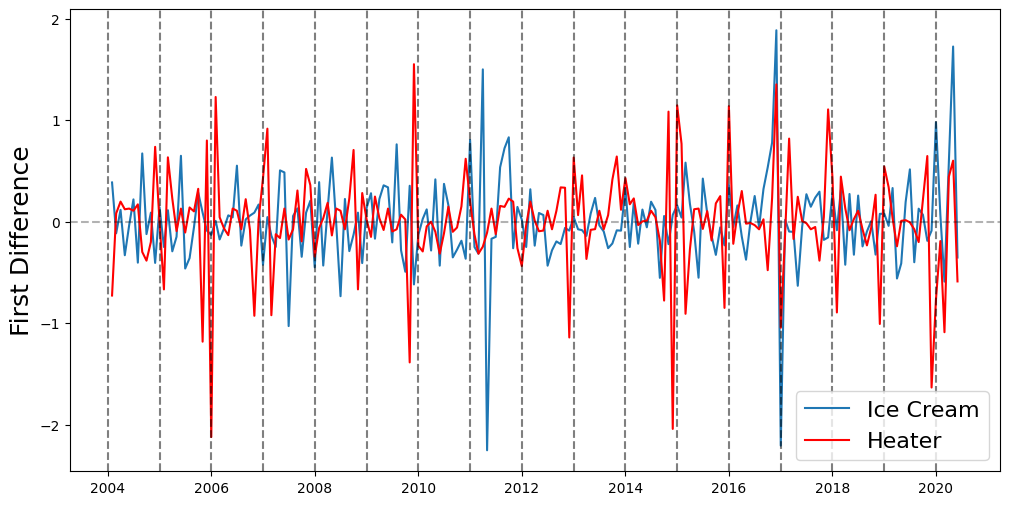

In [212]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

### **Test adf**

In [213]:
result = adfuller(ice_cream_heater_df['ice cream'])


In [214]:
print('Statistiche ADF: %f' % result[0])
print('p-value: %f' % result[1])
print('Valori critici:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

Statistiche ADF: -12.294065
p-value: 0.000000
Valori critici:
	1%: -3.464
	5%: -2.876
	10%: -2.575


In [215]:
result = adfuller(ice_cream_heater_df['heater'])

In [216]:
print('Statistiche ADF: %f' % result[0])
print('p-value: %f' % result[1])
print('Valori critici:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Statistiche ADF: -14.280161
p-value: 0.000000
Valori critici:
	1%: -3.464
	5%: -2.876
	10%: -2.575


### **PACF**

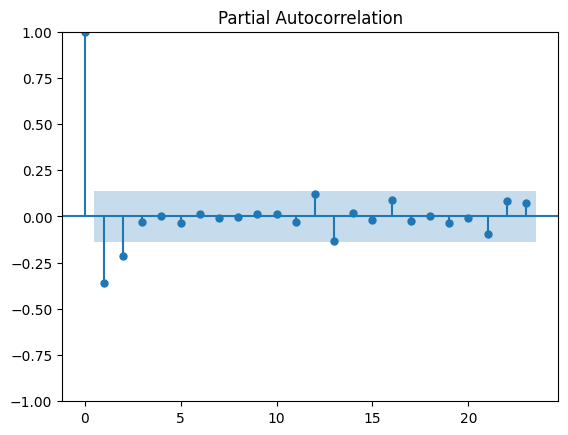

In [217]:
plot_pacf(ice_cream_heater_df['heater'])
plt.show()

In [218]:
for lag in range(1, 14):
    heater_series = ice_cream_heater_df['heater'].iloc[lag:]
    lagged_ice_cream_series = ice_cream_heater_df['ice cream'].iloc[:-lag]
    print('Lag: %s'%lag)
    print(pearsonr(heater_series, lagged_ice_cream_series))
    print('------')

Lag: 1
PearsonRResult(statistic=-0.03154450742591562, pvalue=0.6607284991749419)
------
Lag: 2
PearsonRResult(statistic=-0.09872703210944635, pvalue=0.16970841905089737)
------
Lag: 3
PearsonRResult(statistic=-0.001783855378923574, pvalue=0.9803056762960979)
------
Lag: 4
PearsonRResult(statistic=0.06023971859825543, pvalue=0.4052979832528627)
------
Lag: 5
PearsonRResult(statistic=-0.05403486448015027, pvalue=0.45664426275057074)
------
Lag: 6
PearsonRResult(statistic=0.06461183026553835, pvalue=0.3745300043445426)
------
Lag: 7
PearsonRResult(statistic=-0.04949334618415865, pvalue=0.49768766857620594)
------
Lag: 8
PearsonRResult(statistic=0.07890837135977341, pvalue=0.28045489704330734)
------
Lag: 9
PearsonRResult(statistic=-0.05323501699600429, pvalue=0.4681034202228073)
------
Lag: 10
PearsonRResult(statistic=0.02953698906079116, pvalue=0.6882054906333315)
------
Lag: 11
PearsonRResult(statistic=-0.059795363515225686, pvalue=0.41752174204856696)
------
Lag: 12
PearsonRResult(stat

### **Modello VAR**

In [219]:
ice_cream_heater_df = ice_cream_heater_df[['ice cream', 'heater']]

In [220]:
model = VAR(ice_cream_heater_df)

c:\Users\matia\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [221]:
model_fit = model.fit(maxlags=13)

In [222]:

model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 01, Mar, 2025
Time:                     18:13:48
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.92349
Nobs:                     184.000    HQIC:                  -2.48459
Log likelihood:          -204.405    FPE:                  0.0571123
AIC:                     -2.86700    Det(Omega_mle):       0.0434311
--------------------------------------------------------------------
Results for equation ice cream
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.016054         0.034105           -0.471           0.638
L1.ice cream         -0.287811         0.079633           -3.614           0.000
L1.heater            -0.121251         0.073673         

### **Test modello**

In [228]:
n_obs = 4
train_data = ice_cream_heater_df[:-n_obs]
test_data = ice_cream_heater_df[-n_obs:]

In [229]:
model = VAR(train_data)
lag_order = model.select_order(maxlags=3)  # Massimo 12 lag per dati mensili
best_lag = lag_order.bic

c:\Users\matia\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [230]:
var_model = model.fit(best_lag)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 01, Mar, 2025
Time:                     18:19:08
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.17227
Nobs:                     192.000    HQIC:                  -3.23284
Log likelihood:          -224.562    FPE:                  0.0378523
AIC:                     -3.27407    Det(Omega_mle):       0.0366966
--------------------------------------------------------------------
Results for equation ice cream
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.010665         0.029818           -0.358           0.721
L1.ice cream        -0.255504         0.069773           -3.662           0.000
L1.heater           -0.086525         0.059988           -1.

In [238]:
forecast = var_model.forecast(train_data.values[-best_lag:], steps=n_obs)
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=['heater_pred', 'ice_cream_pred'])

In [239]:
print(forecast_df)

            heater_pred  ice_cream_pred
Month                                  
2020-03-01    -0.011078        0.079840
2020-04-01    -0.014743       -0.020628
2020-05-01    -0.005114        0.016169
2020-06-01    -0.010758        0.002785


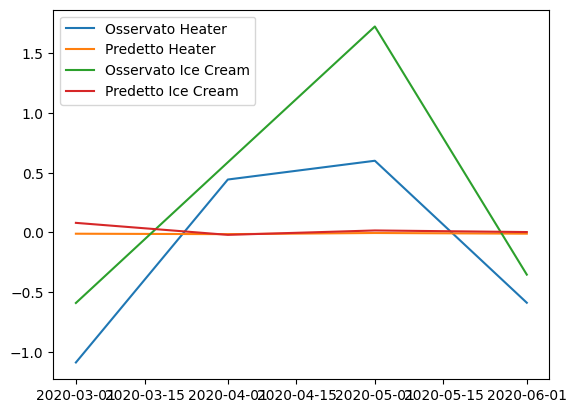

In [240]:
plt.plot(test_data['heater'], label='Osservato Heater')
plt.plot(forecast_df['heater_pred'], label='Predetto Heater')  # Ora heater_pred esiste
plt.plot(test_data['ice cream'], label='Osservato Ice Cream')
plt.plot(forecast_df['ice_cream_pred'], label='Predetto Ice Cream')  # E ice_cream_pred anche
plt.legend()
plt.show()